In [1]:
# Imports & keys 

import os
from dotenv import load_dotenv
import glob
from langchain_anthropic import ChatAnthropic

os.chdir("/workspace")

# initialize API keys
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')

if openai_api_key:
    print(f"API Keys retrieved successfully")
else:
    print("API Keys not found")

API Keys retrieved successfully


## Grundidee der Datensynthese

Ausgangspunkt ist erneut die Knowledge-Base – also eine Sammlung von ausgewählten Artikeln.<br>
<br>
• Schritt 1: **Chunking**: Analog zum RAG-Ablauf splitten wir die Texte zunächst mit einem TextSplitter in einzelne Abschnitte (chunks).<br>
<br>
• Schritt 2: **Zufallssample**: Wir wählen ein zufälligen chunk als Startpunkt aus.<br>
<br>
• Schritt 3: **Kontextgeneration**: Per Cosine-Similarity suchen wir die semantisch ähnlichsten Nachbar-Chunks und fügen sie zu einem gemeinsamen Kontext zusammen. <br>
<br>
• Schritt 4: **Fragegenerierung**: Ein Query-Generator formuliert auf Basis dieses Kontexts passende Nutzerfragen – also die umgekehrte Logik zum Retrieving in RAG. <br>

der gründsätzliche aufbau: grundwahrheit ist erneut unsere knowledge base (also unsere Dokumentensammlung), ähnlich wie beim RAG Prozess auch, werden die Dokumente mittels text splitter gechunkt, also in kleinere Abschnitt aufgeteitl, eine dieser chunks wird zufällig ausgewählt. Dann wird aus diesem chunk ein context generierte, indem via cosine similarity geguckt wird, welche anderen chunks die größte semantische überlappunt mit dem ersten chunk haben. 

Diese Sammlung aus semantisch ähnlichen chunks bildet dann den Context, und basieren aus diesem Kontext werden dann die Fragen generiert, in einer Art umgekehrten Logik. Statt zu mittels retriever gucken, welche chunks zu der gestellten Frage passen, wird mittels query generator geguckt, welche Fragen zu den gebildeten chunks passen.

Man kann mit deepeval den ganzen Prozess noch sehr viel feiner anpassen, z.B. kann man aussuchen, wie viele chunks pro Dokument extrahiert werden sollen, man kann bestimmen aus wie vielen chunks der Kontext generiert sein soll, man kann auch festlegen, wie ähnlich sich die chunks überhaupt sein sollen, um zu einem gemeinsamen Kontext festgelegt zu werden, man kann auch einstellen, wie die Ähnlichkeit zwischen den chunks überhaupt berechnet werden soll. Auch kann man das post-filtern genauer einstellen, also die Qualitätskontrolle nach der initialen Generierung.

All diese Parameter sollte man sich gut überlegen und an den eigenen Bedarf anpassen, aber der Einfachheithalber, werden wir jetzt erstmal nur die default Einstellungen übernehmen. 
Bis auf die chunking Einstellungen, also der 1. Schritt wo die Dokumente gechunkt, also in Abschnitte aufgesplittet werden. Grund: die chunking Angaben, also chunking size und chunking overlap sollten ungefähr so sein, wie beim RAG System auch.

Quellen und mehr Doku:
https://www.confident-ai.com/blog/the-definitive-guide-to-synthetic-data-generation-using-llms

das einzige was wir festlegen sind die styling optionen, hier kann man ganz simpel mit natürlicher sprache beschreiben, wie die fragen aussehen sollen, wie die antworten aussehen sollen, was die aufgabe des systems welches man testen will sein soll, und das szenario in dem dieses system genutzt wird. außerdem lege ich noch das Sprachmodell fest, weil das default modell relativ teuer ist

## Finetuning-Parameter

Grundsätzlich erlaubt das *deepeval* package sehr feines Tuning. Man kann z.B. festlegen:
<br>
<br>
• Wie viele chunks sollen pro Dokument extrahiert werden?
<br>
<br>
• Aus wie vielen chunks soll ein Kontext generiert werden?
<br>
<br>
• Wie soll die Ähnlichkeit zwischen chunks ermittelt werden?
<br>
<br>
• Wie genau soll das Post-Filtering stattfinden?
<br>
<br>
Für diese Demo übernehmen wir die default Einstellungen, mit einer Ausnahme:<br>
Für die chunk_size und den chunk_overlap (also wie klein sollen wie Abschnitte sein und wie sehr sollen sie sich überlappen) nehmen wir dieselben Werte, die wir auch im RAG-System verwendet haben. Damit wird sichergestellt, dass die Test- und Produktions­pipeline gleich sind. Außerdem wählen wir ein günstiges und schnelles LLM für die Fragengenerierung aus.

In [2]:
from deepeval.synthesizer import Synthesizer
from deepeval.synthesizer.config import StylingConfig, ContextConstructionConfig

# define the styling and context construction configurations using natural language
styling_config = StylingConfig(
    input_format=(
        "Natural, conversational questions in German that use everyday language rather than technical terminology." 
        "Questions should use paraphrases and pronouns, and occasionally contain mild irrelevant details." 
        "Each question addresses exactly one scientific aspect.",
    )
    expected_output_format=
        "Concise answers in German, clearly structured citing evidence.",
    task=
        "Answering focused scientific, non-trivial queries that address specific aspects of medical, climate, environment, or technology topics.",
    scenario=
        "Science journalists, scientists, or curious non-experts seeking precise informationon a specific scientific topic they've encountered.",
)

# we use a cheap and fast llm
synthesizer = Synthesizer(
    model="gpt-4o-mini",
    styling_config=styling_config
)

In [ ]:
# define the folder structure
data_dir = "data/example_data"
story_files = glob.glob(f'{data_dir}/*.txt')

# use the same chunking size as before
context_construction_config = ContextConstructionConfig(
    chunk_size=512,
    chunk_overlap=20
    )

# create golden questions and answers from the documents
synthesizer.generate_goldens_from_docs(
    document_paths=story_files,
    include_expected_output=True,
    context_construction_config=context_construction_config
    )


/usr/local/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[Confident AI Synthesizer Log] SUCCESS: Successfully deleted: .vector_db

[Confident AI Synthesizer Log] SUCCESS: Context Construction: Utilizing 29 out of 92 chunks.

[Golden(input='Was sind die besonderen Wirkmechanismen und Nebenwirkungen von KarXT, die es von herkömmlichen Antipsychotika unterscheiden? Gibt es da etwas, das man wissen sollte?', actual_output=None, expected_output='KarXT unterscheidet sich von traditionellen Antipsychotika durch seinen speziellen Wirkmechanismus, der auf M1/M4 muskarineren Agonisten basiert. Dieser Mechanismus reduziert die präsynaptische Dopaminausschüttung, was zu einer anderen Wirkung im Vergleich zu bisherigen Antipsychotika führt, die postsynaptische Dopaminrezeptoren blockieren. Ein weiterer Vorteil ist, dass KarXT im Gegensatz zu vielen herkömmlichen Antipsychotika nicht zu Gewichtszunahme sondern eher zu Gewichtsabnahme führt.\n\nNebenwirkungen wie Übelkeit und gastrointestinale Beschwerden wurden beobachtet, jedoch sollten sie moderat sein, wie die EMERGENT-Studien gezeigt haben. Diese neuen Ansätze könnten helfen, Patienten, die herkömmliche Antipsychotika nicht vertragen, signifikant zu unterstützen.', 

In [9]:
# save the generated synthetic QA pairs to a pandas DataFrame
synthetic_qa_pairs = synthesizer.to_pandas()

In [85]:
for idx in range(0, len(synthetic_qa_pairs[:5])):
    print(f"Number: {idx}")
    print(f"Question: {synthetic_qa_pairs['input'][idx]}")
    print(f"Answer: {synthetic_qa_pairs['expected_output'][idx]}")
    print("---" * 80)

Number: 0
Question: Was sind die besonderen Wirkmechanismen und Nebenwirkungen von KarXT, die es von herkömmlichen Antipsychotika unterscheiden? Gibt es da etwas, das man wissen sollte?
Answer: KarXT unterscheidet sich von traditionellen Antipsychotika durch seinen speziellen Wirkmechanismus, der auf M1/M4 muskarineren Agonisten basiert. Dieser Mechanismus reduziert die präsynaptische Dopaminausschüttung, was zu einer anderen Wirkung im Vergleich zu bisherigen Antipsychotika führt, die postsynaptische Dopaminrezeptoren blockieren. Ein weiterer Vorteil ist, dass KarXT im Gegensatz zu vielen herkömmlichen Antipsychotika nicht zu Gewichtszunahme sondern eher zu Gewichtsabnahme führt.

Nebenwirkungen wie Übelkeit und gastrointestinale Beschwerden wurden beobachtet, jedoch sollten sie moderat sein, wie die EMERGENT-Studien gezeigt haben. Diese neuen Ansätze könnten helfen, Patienten, die herkömmliche Antipsychotika nicht vertragen, signifikant zu unterstützen.
------------------------------

## LLM-basiertes post-hoc filtern
<br>
Die ersten synthetischen Fragen machen bereits einen soliden Eindruck, sind jedoch noch nicht perfekt. Darum lassen wir sie von einem **zweiten LLM** gegen drei klar definierte Bewertungs­kriterien prüfen, die in 3 separaten Prompts formuliert wurden:
<br>
<br>
In diesem Fall geht es v.a. um folgende Punkte: 
<br>
<br>
- Wie genau lässt sich die Fragen mit dem bereitgestellten Kontext beantworten?
<br>
<br>
- Wie relevant sind die Fragen überhaupt für das Zielpublikum, also Wissenschaftsjournalist*innen oder interessierte Laien?
<br>
<br>
- Inwiefern ergibt die Frage ohne Kontext überhaupt Sinn? 
<br>
<br>
Das Bewertungs-LLM vergibt für jedes Kriterium **einen Score von 1 bis 5**. Diese Werte bilden anschließend die Grundlage für unseren Qualitäts­filter.

In [70]:
from data.prompts.evaluation_prompts import (
    question_groundedness_critique_prompt,
    question_relevance_critique_prompt,
    question_standalone_critique_prompt
)

evaluation_llm = ChatAnthropic(
        model_name="claude-3-5-haiku-20241022",
        temperature=0,
        max_tokens=512,
        verbose=False
    )

# Create a dictionary of critique prompts
critique_prompts = {
    "groundedness": question_groundedness_critique_prompt,
    "relevance": question_relevance_critique_prompt,
    "standalone": question_standalone_critique_prompt
}

from src.utils.synth_data_creation import evaluate_qa_pairs

# Evaluate the synthetic QA pairs using the critique prompts
eval_qa_pairs = evaluate_qa_pairs(
    synthetic_qa_pairs, 
    critique_prompts, 
    evaluation_llm
    )

# save the evaluated QA pairs to a CSV file, because this is the longest and most expensive step
eval_qa_pairs.to_csv("data/synthetic_qa_pairs.csv", index=False)

In [ ]:
# this is what a typical output looks like
eval_qa_pairs.iloc[0].to_dict()

{'input': 'Was sind die besonderen Wirkmechanismen und Nebenwirkungen von KarXT, die es von herkömmlichen Antipsychotika unterscheiden? Gibt es da etwas, das man wissen sollte?',
 'actual_output': None,
 'expected_output': 'KarXT unterscheidet sich von traditionellen Antipsychotika durch seinen speziellen Wirkmechanismus, der auf M1/M4 muskarineren Agonisten basiert. Dieser Mechanismus reduziert die präsynaptische Dopaminausschüttung, was zu einer anderen Wirkung im Vergleich zu bisherigen Antipsychotika führt, die postsynaptische Dopaminrezeptoren blockieren. Ein weiterer Vorteil ist, dass KarXT im Gegensatz zu vielen herkömmlichen Antipsychotika nicht zu Gewichtszunahme sondern eher zu Gewichtsabnahme führt.\n\nNebenwirkungen wie Übelkeit und gastrointestinale Beschwerden wurden beobachtet, jedoch sollten sie moderat sein, wie die EMERGENT-Studien gezeigt haben. Diese neuen Ansätze könnten helfen, Patienten, die herkömmliche Antipsychotika nicht vertragen, signifikant zu unterstützen

In [83]:
from src.utils.synth_data_creation import process_evaluation_scores

# eventually, we compute an overall average score (groundedness, relevance, standalone) for each question and remove the bottom 15% of questions based on this score
filtered_df = process_evaluation_scores(
    eval_qa_pairs,
    groundedness_weight=0.35,
    standalone_weight=0.35,
    relevance_weight=0.3,
    bottom_percent_remove=15
)

,input,actual_output,expected_output,context,retrieval_context,n_chunks_per_context,context_length,evolutions,context_quality,synthetic_input_quality,...,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval,grounded_norm,standalone_norm,relevance_norm,total_score
0,Wie beeinflusst KarXT das Gewicht im Vergleich...,None,KarXT führt im Vergleich zu vielen anderen Ant...,[ikamentes noch relativ umständlich ist: Es mu...,None,3,3718,[In-Breadth],None,0.8,...,3,The context provides some information about Ka...,5,This is a well-focused scientific question abo...,1,The question contains multiple subquestions an...,1.0,0.0,1.0,0.65


Und dann bin ich fast fertig. Denn was eigentlich sogar noch wichtiger ist als die Qualität der Frage/Antwort Paare, ist die Diversität der Fragen. Wenn ich abwägen müsste, in ein testset mit vielleicht qualitativ nicht so hochwertigen Fragen, welche aber sehr divers sind, besser, als testsets die zwar sehr hochwertig sind, aber sehr ähnlich sind. Siehe: https://msukhareva.substack.com/p/synthetic-datasets-for-applied-ai

Die Diversität bzw. Ähnlichkeit wird wieder gemessen mittels cosine similarity. Als rule-of-thumb gilt, über .6 = sehr undivers, und unter .4 = ausreichend divers.
In unserem Fall ist der Mittelwert zwar gut (bei 0.3), aber an der Verteilung sieht man, dass es ein cluster an sehr ähnlichen Fragen gibt. Das ist auch nicht weiter verwunderlich, weil wir nur 5 verschiedene Artikel haben, auf denen unsere X Fragen basieren. In der Regel sollten die Fragen diverser sein, je diverser die knowledge base ist. Wenn das nicht der Fall ist, müsste man nochmal genauer gucken und zu ähnliche Fragen entfernen, aber das würde den Rahmen sprengen...

## Diversität prüfen  

Als letztes prüfen wir **Diversität** der Fragen.  <br>
Ein weniger perfektes, aber breit gestreutes Set deckt deutlich mehr Fehlerquellen auf als ein sauberes, jedoch monotones Set.
<br>
### Messgröße  
Dafür nutzen wir erneut die **mittlere paarweise Cosine-Similarity**. Als rule-of-thumb kann man sich an folgende Werte orientieren:
<br>
| Richtwert | Interpretation |
|-----------|----------------|
| **> 0.60** | starke Redundanz → kaum neue Fehlerfälle |
| **< 0.40** | genügend Diversität für praxisnahe RAG-Tests |


[Confident AI Synthesizer Log] SUCCESS: Successfully deleted: /root/.cache/huggingface/hub/models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2/tmpqokgglyp


Batches:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Mean similarity: 0.3017
Std  similarity: 0.2751


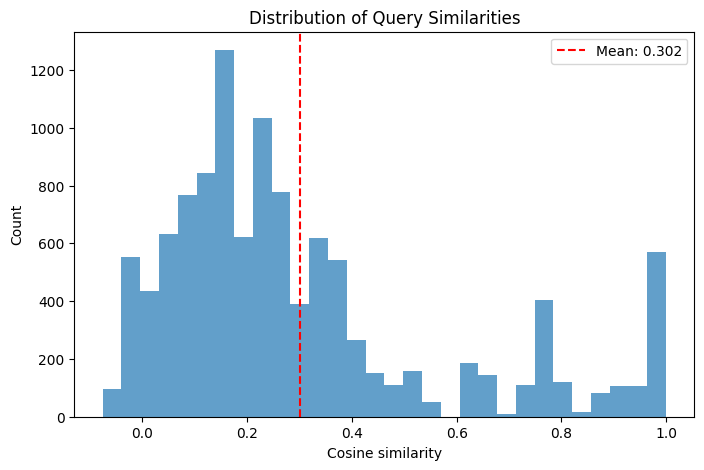

In [75]:
sims, sim_matrix = analyze_semantic_similarity(synthetic_qa_pairs)

In [76]:
synthetic_qa_pairs

,input,actual_output,expected_output,context,retrieval_context,n_chunks_per_context,context_length,evolutions,context_quality,synthetic_input_quality,source_file
0,Was sind die besonderen Wirkmechanismen und Ne...,None,KarXT unterscheidet sich von traditionellen An...,[ikamentes noch relativ umständlich ist: Es mu...,None,3,3718,[Multi-context],None,0.8,data/example_data/10_Copernicus-Report_ 2024 w...
1,Wie beeinflusst KarXT das Gewicht im Vergleich...,None,KarXT führt im Vergleich zu vielen anderen Ant...,[ikamentes noch relativ umständlich ist: Es mu...,None,3,3718,[In-Breadth],None,0.8,data/example_data/10_Copernicus-Report_ 2024 w...
2,Was sind die besonderen Wirkmechanismen und Ne...,None,KarXT unterscheidet sich von traditionellen An...,[ikamentes noch relativ umständlich ist: Es mu...,None,3,3718,[Multi-context],None,0.8,data/example_data/10_Copernicus-Report_ 2024 w...
3,Wie beeinflusst KarXT das Gewicht im Vergleich...,None,KarXT führt im Vergleich zu vielen anderen Ant...,[ikamentes noch relativ umständlich ist: Es mu...,None,3,3718,[In-Breadth],None,0.8,data/example_data/10_Copernicus-Report_ 2024 w...
4,Wie wirkt sich Künstliche Intelligenz auf die ...,None,Künstliche Intelligenz hat erheblichen Einflus...,[liche Gemeinschaft muss kontinuierlich an der...,None,3,4025,[Constrained],None,0.8,data/example_data/10_Copernicus-Report_ 2024 w...
...,...,...,...,...,...,...,...,...,...,...,...
145,"Erwartet man, dass die Temperaturen auf der Er...",None,"Ja, die Temperaturen auf der Erde werden in de...","[wa 50 Prozent beträgt, dass einzelne Jahre di...",None,3,3849,[Multi-context],None,0.5,data/example_data/10_Copernicus-Report_ 2024 w...
146,Wie beeinflussen niedrige Windenergieerträge d...,None,Niedrige Windenergieerträge führen zu hohen St...,[TITLE: Dunkelflauten: Wie hohe Strompreise ge...,None,3,3997,[Constrained],None,0.7,data/example_data/10_Copernicus-Report_ 2024 w...
147,Wie beeinflussen die hohen Strompreise in Deut...,None,Die hohen Strompreise in Deutschland beeinflus...,[TITLE: Dunkelflauten: Wie hohe Strompreise ge...,None,3,3997,[Reasoning],None,0.7,data/example_data/10_Copernicus-Report_ 2024 w...
148,Warum bleiben die Strompreise für Haushaltskun...,None,Die Strompreise für Haushaltskunden bleiben st...,[herpreis: \n„Für die allermeisten Haushaltsku...,None,3,3865,[Concretizing],None,0.6,data/example_data/10_Copernicus-Report_ 2024 w...


## Zusammenfassung unseres Mini-Sets  
* Mean = **0.x0** – also grundsätzlich gut.  
* Das Histogramm zeigt jedoch ein klares Cluster sehr ähnlicher Fragen.  

Das ist nicht weiter überraschend, die Queries stammen schließlich aus nur sehr wenigen Artikeln.<br>  
Allgemein kann man jedoch sagen: Je heterogener die Knowledge-Base, desto vielfältiger die Fragen.<br>
Andernfalls hilft gezieltes *De-Duplizieren*, das würde aber den Rahmen dieses Workshops sprengen.<br>
<br>
Am Ende sollte man die Fragen trotzdem noch manuell prüfen.<br>
So bekommt man ein Gefühl für Stil, Tiefe und Kontext – und kannst offensichtlich unbrauchbare oder schlechte Fragen direkt entfernen.<br>
<br>
Hier noch ein paar Quellen und weiterführende Links:<br>
<br>
 [Hintergrund zur Erstellung synthetische Datensets](https://www.confident-ai.com/blog/the-definitive-guide-to-synthetic-data-generation-using-llms)<br>
 [deepeval Doku](https://deepeval.com/docs/synthesizer-introduction)<br>
 [Ein bisschen theoretischer Hintergrund in leicht aufbereitet](https://msukhareva.substack.com/p/synthetic-datasets-for-applied-ai)<br>
